In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load all trips and filter by SOC change > 5%
trip_files = sorted(glob('BMW_i3_Dataset/Trip*.csv'))
print(f"Total trip files: {len(trip_files)}")

valid_trips = []
for trip_file in trip_files:
    df = pd.read_csv(trip_file, sep=';', encoding='latin-1')
    soc_change = df['SoC [%]'].iloc[0] - df['SoC [%]'].iloc[-1]
    
    if soc_change > 5:  # Only trips with >5% SOC change
        trip_name = trip_file.split('\\')[-1]
        valid_trips.append((trip_name, df, soc_change))

print(f"Valid trips (SOC change > 5%): {len(valid_trips)}")

Total trip files: 70
Valid trips (SOC change > 5%): 39


In [3]:
# Process each trip: calculate remaining distance and time at each point
trip_segments = []

for trip_name, df, _ in valid_trips:
    # Get column names
    velocity_col = [col for col in df.columns if 'Velocity' in col][0]
    soc_col = [col for col in df.columns if 'SoC' in col and 'displayed' not in col and 'min' not in col and 'max' not in col][0]
    
    # Remove idle segments (velocity < 0.5 km/h)
    df_moving = df[df[velocity_col] > 0.5].copy().reset_index(drop=True)
    
    if len(df_moving) < 100:
        continue
    
    # Calculate cumulative distance (velocity is in km/h, sampling at 10Hz = 0.1s intervals)
    df_moving['Distance_km'] = (df_moving[velocity_col] / 3600) * 0.1  # km per 0.1s
    df_moving['Cumulative_Distance'] = df_moving['Distance_km'].cumsum()
    
    # Calculate time elapsed (in minutes)
    df_moving['Time_minutes'] = np.arange(len(df_moving)) * 0.1 / 60  # 0.1s per sample
    
    # For each point, calculate remaining distance and time from current to end of trip
    total_distance = df_moving['Cumulative_Distance'].iloc[-1]
    total_time = df_moving['Time_minutes'].iloc[-1]
    
    df_moving['Remaining_Distance'] = total_distance - df_moving['Cumulative_Distance']
    df_moving['Remaining_Time'] = total_time - df_moving['Time_minutes']
    
    # Only keep points where remaining distance > 0.5 km and remaining time > 2 min
    df_filtered = df_moving[(df_moving['Remaining_Distance'] > 0.5) & 
                             (df_moving['Remaining_Time'] > 2)].copy()
    
    if len(df_filtered) > 50:
        df_filtered['Trip'] = trip_name
        trip_segments.append(df_filtered)

data = pd.concat(trip_segments, ignore_index=True)
print(f"\nTotal samples: {len(data):,}")
print(f"Distance range: {data['Remaining_Distance'].min():.2f} to {data['Remaining_Distance'].max():.2f} km")
print(f"Time range: {data['Remaining_Time'].min():.1f} to {data['Remaining_Time'].max():.1f} minutes")


Total samples: 512,001
Distance range: 0.51 to 60.97 km
Time range: 2.0 to 56.3 minutes


In [4]:
# Feature engineering
col_map = {}
for pattern in ['Battery Voltage', 'Battery Current', 'Battery Temperature', 'Ambient Temperature', 
                'Velocity', 'Elevation', 'SoC']:
    matching = [col for col in data.columns if pattern in col and 'displayed' not in col and 'min' not in col and 'max' not in col]
    if matching:
        col_map[pattern] = matching[0]

print("Column mapping:")
for k, v in col_map.items():
    print(f"  {k} -> {v}")

# Calculate power consumption and efficiency metrics
data['Power [W]'] = data[col_map['Battery Voltage']] * data[col_map['Battery Current']]
data['Velocity_squared'] = data[col_map['Velocity']] ** 2
data['Temp_diff'] = data[col_map['Battery Temperature']] - data[col_map['Ambient Temperature']]

# Energy consumption rate (Wh/km) - rolling average over last 10 samples
data['Energy_rate'] = data['Power [W]'] / (data[col_map['Velocity']] + 0.01)  # Avoid division by zero
data['Energy_rate_smooth'] = data['Energy_rate'].rolling(window=10, min_periods=1).mean()

# Elevation gradient (change in elevation)
data['Elevation_gradient'] = data[col_map['Elevation']].diff().fillna(0)

print(f"\nFeatures created successfully")

Column mapping:
  Battery Voltage -> Battery Voltage [V]
  Battery Current -> Battery Current [A]
  Battery Temperature -> Battery Temperature [°C]
  Ambient Temperature -> Ambient Temperature [°C]
  Velocity -> Velocity [km/h]
  Elevation -> Elevation [m]
  SoC -> SoC [%]

Features created successfully


In [5]:
# Select features for range prediction
feature_cols = [
    col_map['SoC'],
    col_map['Battery Voltage'],
    col_map['Battery Current'],
    col_map['Battery Temperature'],
    col_map['Ambient Temperature'],
    col_map['Velocity'],
    col_map['Elevation'],
    'Power [W]',
    'Velocity_squared',
    'Temp_diff',
    'Energy_rate_smooth',
    'Elevation_gradient'
]

# Prepare data for distance prediction
distance_data = data[feature_cols + ['Remaining_Distance']].copy().dropna()
print(f"Distance prediction samples: {len(distance_data):,}")

X_dist = distance_data[feature_cols].values
y_dist = distance_data['Remaining_Distance'].values

# Prepare data for time prediction
time_data = data[feature_cols + ['Remaining_Time']].copy().dropna()
print(f"Time prediction samples: {len(time_data):,}")

X_time = time_data[feature_cols].values
y_time = time_data['Remaining_Time'].values

print(f"\nFeatures: {len(feature_cols)}")

Distance prediction samples: 498,305
Time prediction samples: 498,305

Features: 12


In [6]:
# Train-test split for distance prediction
X_train_dist, X_test_dist, y_train_dist, y_test_dist = train_test_split(
    X_dist, y_dist, test_size=0.2, random_state=42
)

print("DISTANCE PREDICTION SPLIT:")
print(f"  Training samples: {len(X_train_dist):,}")
print(f"  Testing samples: {len(X_test_dist):,}")
print(f"  Train range: {y_train_dist.min():.2f} to {y_train_dist.max():.2f} km")
print(f"  Test range: {y_test_dist.min():.2f} to {y_test_dist.max():.2f} km")

DISTANCE PREDICTION SPLIT:
  Training samples: 398,644
  Testing samples: 99,661
  Train range: 0.51 to 60.97 km
  Test range: 0.51 to 60.97 km


In [7]:
# Train-test split for time prediction
X_train_time, X_test_time, y_train_time, y_test_time = train_test_split(
    X_time, y_time, test_size=0.2, random_state=42
)

print("TIME PREDICTION SPLIT:")
print(f"  Training samples: {len(X_train_time):,}")
print(f"  Testing samples: {len(X_test_time):,}")
print(f"  Train range: {y_train_time.min():.1f} to {y_train_time.max():.1f} minutes")
print(f"  Test range: {y_test_time.min():.1f} to {y_test_time.max():.1f} minutes")

TIME PREDICTION SPLIT:
  Training samples: 398,644
  Testing samples: 99,661
  Train range: 2.0 to 56.3 minutes
  Test range: 2.0 to 56.3 minutes


In [8]:
# Scale features for distance prediction
scaler_dist = StandardScaler()
X_train_dist_scaled = scaler_dist.fit_transform(X_train_dist)
X_test_dist_scaled = scaler_dist.transform(X_test_dist)

print("Distance features scaled")

Distance features scaled


In [9]:
# Scale features for time prediction
scaler_time = StandardScaler()
X_train_time_scaled = scaler_time.fit_transform(X_train_time)
X_test_time_scaled = scaler_time.transform(X_test_time)

print("Time features scaled")

Time features scaled


In [10]:
# Train Random Forest for DISTANCE prediction
rf_dist = RandomForestRegressor(n_estimators=200, max_depth=25, min_samples_split=10,
                                 random_state=42, n_jobs=-1)
rf_dist.fit(X_train_dist_scaled, y_train_dist)

y_pred_dist_train = rf_dist.predict(X_train_dist_scaled)
y_pred_dist_test = rf_dist.predict(X_test_dist_scaled)

dist_train_r2 = r2_score(y_train_dist, y_pred_dist_train)
dist_test_r2 = r2_score(y_test_dist, y_pred_dist_test)
dist_test_rmse = np.sqrt(mean_squared_error(y_test_dist, y_pred_dist_test))
dist_test_mae = mean_absolute_error(y_test_dist, y_pred_dist_test)

print("DISTANCE PREDICTION - Random Forest:")
print(f"  Train R²: {dist_train_r2:.4f}")
print(f"  Test R²: {dist_test_r2:.4f}")
print(f"  Test RMSE: {dist_test_rmse:.3f} km")
print(f"  Test MAE: {dist_test_mae:.3f} km")

DISTANCE PREDICTION - Random Forest:
  Train R²: 1.0000
  Test R²: 1.0000
  Test RMSE: 0.054 km
  Test MAE: 0.005 km


In [11]:
# Train Gradient Boosting for DISTANCE prediction
gb_dist = GradientBoostingRegressor(n_estimators=200, max_depth=8, learning_rate=0.1,
                                     min_samples_split=10, random_state=42)
gb_dist.fit(X_train_dist_scaled, y_train_dist)

y_pred_dist_gb_train = gb_dist.predict(X_train_dist_scaled)
y_pred_dist_gb_test = gb_dist.predict(X_test_dist_scaled)

dist_gb_train_r2 = r2_score(y_train_dist, y_pred_dist_gb_train)
dist_gb_test_r2 = r2_score(y_test_dist, y_pred_dist_gb_test)
dist_gb_test_rmse = np.sqrt(mean_squared_error(y_test_dist, y_pred_dist_gb_test))
dist_gb_test_mae = mean_absolute_error(y_test_dist, y_pred_dist_gb_test)

print("DISTANCE PREDICTION - Gradient Boosting:")
print(f"  Train R²: {dist_gb_train_r2:.4f}")
print(f"  Test R²: {dist_gb_test_r2:.4f}")
print(f"  Test RMSE: {dist_gb_test_rmse:.3f} km")
print(f"  Test MAE: {dist_gb_test_mae:.3f} km")

DISTANCE PREDICTION - Gradient Boosting:
  Train R²: 0.9995
  Test R²: 0.9994
  Test RMSE: 0.269 km
  Test MAE: 0.174 km


In [12]:
# Train Random Forest for TIME prediction
rf_time = RandomForestRegressor(n_estimators=200, max_depth=25, min_samples_split=10,
                                 random_state=42, n_jobs=-1)
rf_time.fit(X_train_time_scaled, y_train_time)

y_pred_time_train = rf_time.predict(X_train_time_scaled)
y_pred_time_test = rf_time.predict(X_test_time_scaled)

time_train_r2 = r2_score(y_train_time, y_pred_time_train)
time_test_r2 = r2_score(y_test_time, y_pred_time_test)
time_test_rmse = np.sqrt(mean_squared_error(y_test_time, y_pred_time_test))
time_test_mae = mean_absolute_error(y_test_time, y_pred_time_test)

print("TIME PREDICTION - Random Forest:")
print(f"  Train R²: {time_train_r2:.4f}")
print(f"  Test R²: {time_test_r2:.4f}")
print(f"  Test RMSE: {time_test_rmse:.3f} minutes")
print(f"  Test MAE: {time_test_mae:.3f} minutes")

TIME PREDICTION - Random Forest:
  Train R²: 1.0000
  Test R²: 1.0000
  Test RMSE: 0.034 minutes
  Test MAE: 0.004 minutes


In [13]:
# Train Gradient Boosting for TIME prediction
gb_time = GradientBoostingRegressor(n_estimators=200, max_depth=8, learning_rate=0.1,
                                     min_samples_split=10, random_state=42)
gb_time.fit(X_train_time_scaled, y_train_time)

y_pred_time_gb_train = gb_time.predict(X_train_time_scaled)
y_pred_time_gb_test = gb_time.predict(X_test_time_scaled)

time_gb_train_r2 = r2_score(y_train_time, y_pred_time_gb_train)
time_gb_test_r2 = r2_score(y_test_time, y_pred_time_gb_test)
time_gb_test_rmse = np.sqrt(mean_squared_error(y_test_time, y_pred_time_gb_test))
time_gb_test_mae = mean_absolute_error(y_test_time, y_pred_time_gb_test)

print("TIME PREDICTION - Gradient Boosting:")
print(f"  Train R²: {time_gb_train_r2:.4f}")
print(f"  Test R²: {time_gb_test_r2:.4f}")
print(f"  Test RMSE: {time_gb_test_rmse:.3f} minutes")
print(f"  Test MAE: {time_gb_test_mae:.3f} minutes")

TIME PREDICTION - Gradient Boosting:
  Train R²: 0.9993
  Test R²: 0.9992
  Test RMSE: 0.285 minutes
  Test MAE: 0.193 minutes


In [14]:
# Feature importance for distance prediction
dist_importance = pd.DataFrame({
    'Feature': feature_cols,
    'RF_Importance': rf_dist.feature_importances_,
    'GB_Importance': gb_dist.feature_importances_
}).sort_values('RF_Importance', ascending=False)

print("\nDISTANCE PREDICTION - Feature Importance:")
print(dist_importance)


DISTANCE PREDICTION - Feature Importance:
                     Feature  RF_Importance  GB_Importance
3   Battery Temperature [°C]       0.397563       0.404783
0                    SoC [%]       0.303020       0.269259
6              Elevation [m]       0.125928       0.118471
4   Ambient Temperature [°C]       0.075567       0.082120
9                  Temp_diff       0.039737       0.066891
5            Velocity [km/h]       0.024915       0.030227
8           Velocity_squared       0.023522       0.016575
11        Elevation_gradient       0.009439       0.010978
10        Energy_rate_smooth       0.000213       0.000097
1        Battery Voltage [V]       0.000067       0.000441
7                  Power [W]       0.000014       0.000116
2        Battery Current [A]       0.000013       0.000041


In [15]:
# Feature importance for time prediction
time_importance = pd.DataFrame({
    'Feature': feature_cols,
    'RF_Importance': rf_time.feature_importances_,
    'GB_Importance': gb_time.feature_importances_
}).sort_values('RF_Importance', ascending=False)

print("\nTIME PREDICTION - Feature Importance:")
print(time_importance)


TIME PREDICTION - Feature Importance:
                     Feature  RF_Importance  GB_Importance
3   Battery Temperature [°C]       0.355867       0.352257
0                    SoC [%]       0.338288       0.312130
6              Elevation [m]       0.145521       0.141372
9                  Temp_diff       0.077561       0.090119
4   Ambient Temperature [°C]       0.051593       0.066666
8           Velocity_squared       0.010721       0.012155
11        Elevation_gradient       0.010678       0.011607
5            Velocity [km/h]       0.009620       0.012140
1        Battery Voltage [V]       0.000111       0.001342
10        Energy_rate_smooth       0.000020       0.000100
7                  Power [W]       0.000011       0.000085
2        Battery Current [A]       0.000009       0.000027


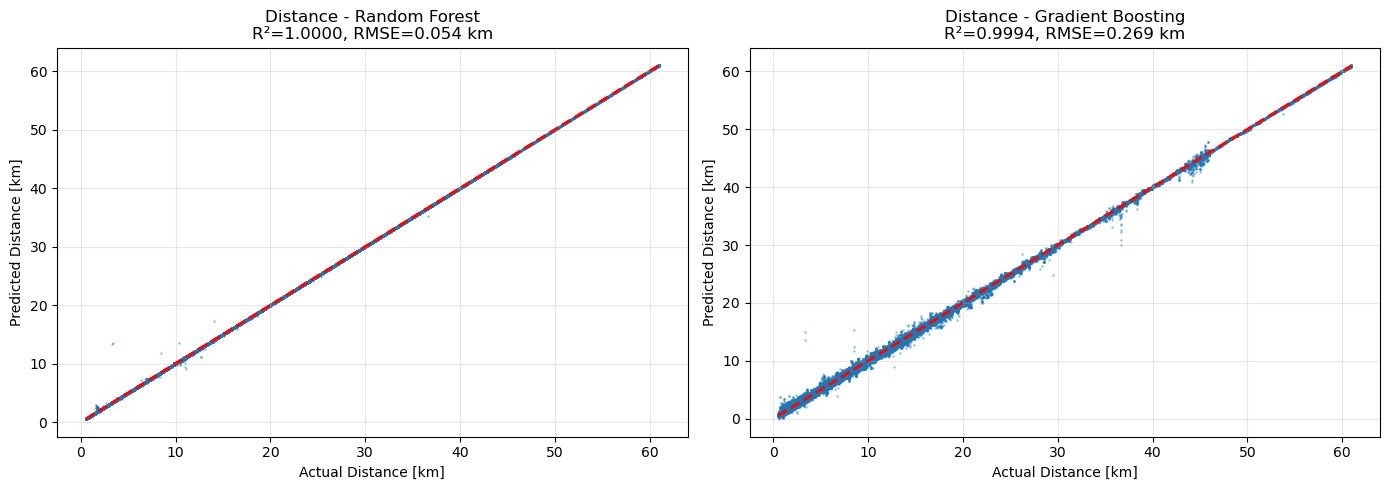

In [16]:
# Visualize distance predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest
axes[0].scatter(y_test_dist, y_pred_dist_test, alpha=0.3, s=1)
axes[0].plot([y_test_dist.min(), y_test_dist.max()], [y_test_dist.min(), y_test_dist.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Distance [km]')
axes[0].set_ylabel('Predicted Distance [km]')
axes[0].set_title(f'Distance - Random Forest\nR²={dist_test_r2:.4f}, RMSE={dist_test_rmse:.3f} km')
axes[0].grid(True, alpha=0.3)

# Gradient Boosting
axes[1].scatter(y_test_dist, y_pred_dist_gb_test, alpha=0.3, s=1)
axes[1].plot([y_test_dist.min(), y_test_dist.max()], [y_test_dist.min(), y_test_dist.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Distance [km]')
axes[1].set_ylabel('Predicted Distance [km]')
axes[1].set_title(f'Distance - Gradient Boosting\nR²={dist_gb_test_r2:.4f}, RMSE={dist_gb_test_rmse:.3f} km')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

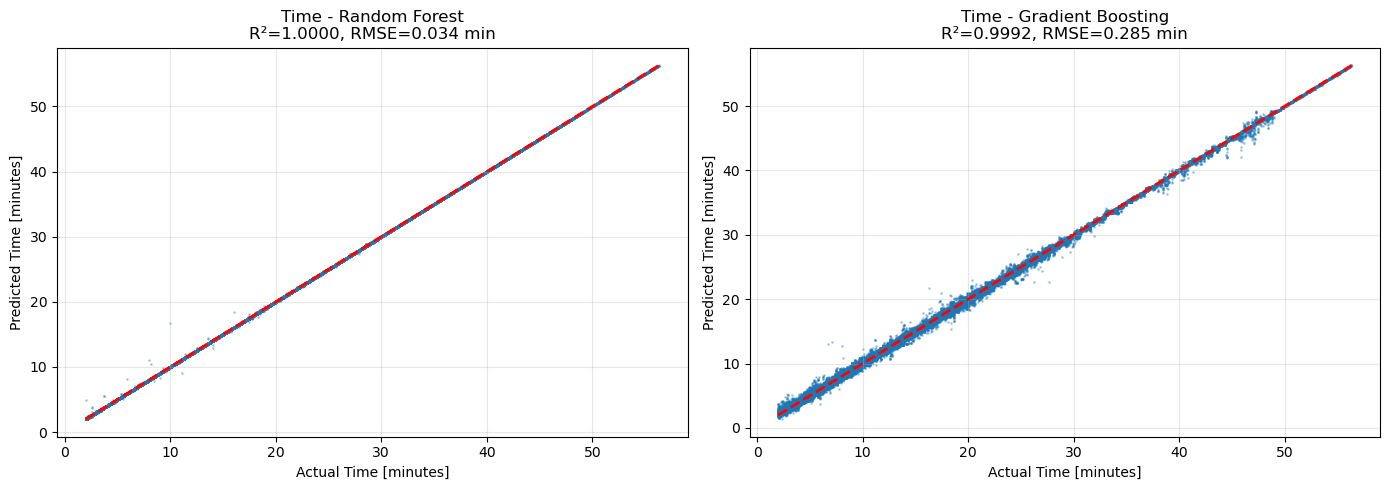

In [17]:
# Visualize time predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest
axes[0].scatter(y_test_time, y_pred_time_test, alpha=0.3, s=1)
axes[0].plot([y_test_time.min(), y_test_time.max()], [y_test_time.min(), y_test_time.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Time [minutes]')
axes[0].set_ylabel('Predicted Time [minutes]')
axes[0].set_title(f'Time - Random Forest\nR²={time_test_r2:.4f}, RMSE={time_test_rmse:.3f} min')
axes[0].grid(True, alpha=0.3)

# Gradient Boosting
axes[1].scatter(y_test_time, y_pred_time_gb_test, alpha=0.3, s=1)
axes[1].plot([y_test_time.min(), y_test_time.max()], [y_test_time.min(), y_test_time.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Time [minutes]')
axes[1].set_ylabel('Predicted Time [minutes]')
axes[1].set_title(f'Time - Gradient Boosting\nR²={time_gb_test_r2:.4f}, RMSE={time_gb_test_rmse:.3f} min')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

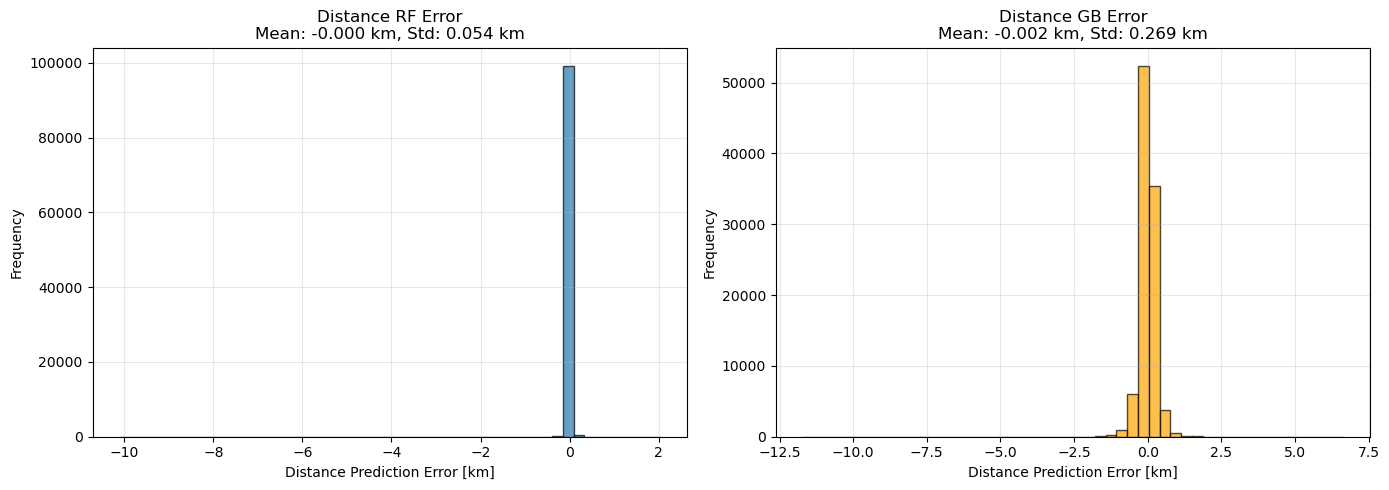

In [18]:
# Error distributions for distance
errors_dist_rf = y_test_dist - y_pred_dist_test
errors_dist_gb = y_test_dist - y_pred_dist_gb_test

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(errors_dist_rf, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Distance Prediction Error [km]')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Distance RF Error\nMean: {errors_dist_rf.mean():.3f} km, Std: {errors_dist_rf.std():.3f} km')
axes[0].grid(True, alpha=0.3)

axes[1].hist(errors_dist_gb, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Distance Prediction Error [km]')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Distance GB Error\nMean: {errors_dist_gb.mean():.3f} km, Std: {errors_dist_gb.std():.3f} km')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

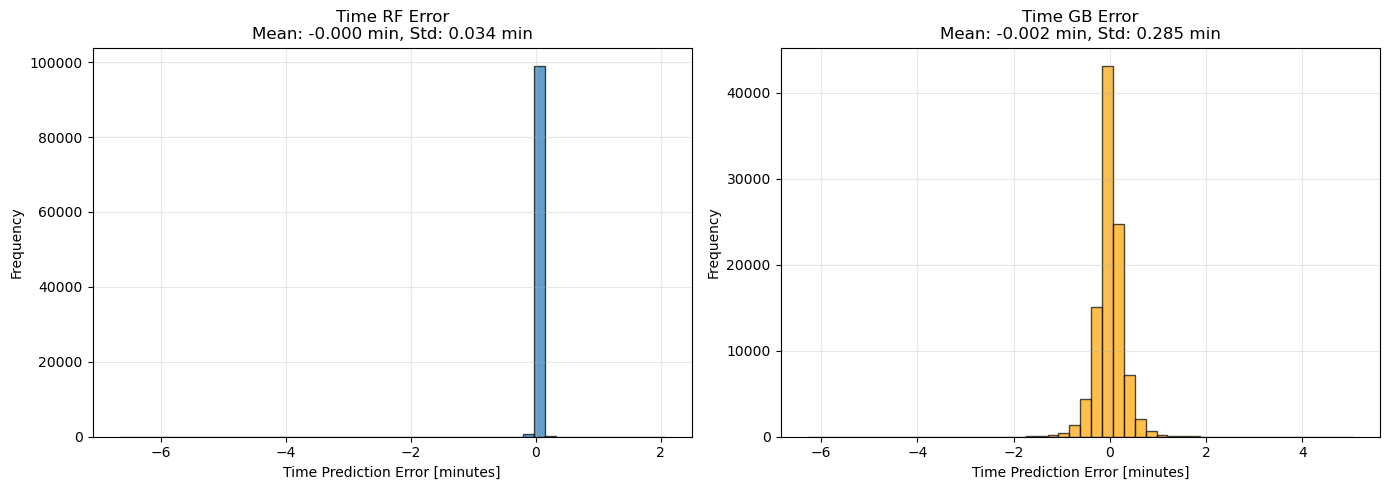

In [19]:
# Error distributions for time
errors_time_rf = y_test_time - y_pred_time_test
errors_time_gb = y_test_time - y_pred_time_gb_test

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(errors_time_rf, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Time Prediction Error [minutes]')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Time RF Error\nMean: {errors_time_rf.mean():.3f} min, Std: {errors_time_rf.std():.3f} min')
axes[0].grid(True, alpha=0.3)

axes[1].hist(errors_time_gb, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Time Prediction Error [minutes]')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Time GB Error\nMean: {errors_time_gb.mean():.3f} min, Std: {errors_time_gb.std():.3f} min')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# Summary
print("="*70)
print("RANGE PREDICTION MODEL SUMMARY")
print("="*70)

print(f"\nDataset: {len(data):,} samples from {len(valid_trips)} trips")
print(f"Features: {len(feature_cols)}")

print("\n--- DISTANCE PREDICTION ---")
best_dist_model = 'Random Forest' if dist_test_r2 > dist_gb_test_r2 else 'Gradient Boosting'
print(f"Best Model: {best_dist_model}")
print(f"  R² Score: {max(dist_test_r2, dist_gb_test_r2):.4f}")
print(f"  RMSE: {min(dist_test_rmse, dist_gb_test_rmse):.3f} km")
print(f"  MAE: {min(dist_test_mae, dist_gb_test_mae):.3f} km")
print(f"\nTop 3 Important Features:")
for i, row in dist_importance.head(3).iterrows():
    print(f"  {row['Feature']}: {row['RF_Importance']:.3f}")

print("\n--- TIME PREDICTION ---")
best_time_model = 'Random Forest' if time_test_r2 > time_gb_test_r2 else 'Gradient Boosting'
print(f"Best Model: {best_time_model}")
print(f"  R² Score: {max(time_test_r2, time_gb_test_r2):.4f}")
print(f"  RMSE: {min(time_test_rmse, time_gb_test_rmse):.3f} minutes")
print(f"  MAE: {min(time_test_mae, time_gb_test_mae):.3f} minutes")
print(f"\nTop 3 Important Features:")
for i, row in time_importance.head(3).iterrows():
    print(f"  {row['Feature']}: {row['RF_Importance']:.3f}")

print("="*70)

RANGE PREDICTION MODEL SUMMARY

Dataset: 512,001 samples from 39 trips
Features: 12

--- DISTANCE PREDICTION ---
Best Model: Random Forest
  R² Score: 1.0000
  RMSE: 0.054 km
  MAE: 0.005 km

Top 3 Important Features:
  Battery Temperature [°C]: 0.398
  SoC [%]: 0.303
  Elevation [m]: 0.126

--- TIME PREDICTION ---
Best Model: Random Forest
  R² Score: 1.0000
  RMSE: 0.034 minutes
  MAE: 0.004 minutes

Top 3 Important Features:
  Battery Temperature [°C]: 0.356
  SoC [%]: 0.338
  Elevation [m]: 0.146
